In [29]:
%%capture
!pip install wandb

In [8]:
import os
import cv2
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [9]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 70
NUM_FEATURES = 512

### DataPreprocessing

In [3]:
label_path = '/content/drive/MyDrive/database(word) (1).csv'
#video path
path2data = '/content/drive/MyDrive/Rtrain/sorted_videos/0'
#validation
vlabel_path = '/content/drive/MyDrive/validation_data(clean).csv'

In [ ]:
label_df = pd.read_csv(label_path)
df1 = label_df[label_df['category']==0]
df1 = df1.drop(columns = ['category','duration','start','end',	'word_length'])

values_to_remove = ['편두통','뻔뻔2']

df1 = df1[~df1['word'].isin(values_to_remove)]
df1 = df1[df1['filename'].str.contains('_F.mp4')]

vlabel_df = pd.read_csv(vlabel_path)

df2 = vlabel_df[vlabel_df['category']==0]
df2 = df2.drop(columns = ['category','duration','start','end','data_type','frame','label'])
df2 = df2[df2['filename'].str.contains('_F')]
df2['filename'] = df2['filename'] + '.mp4'
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df

#### 동음이의어 수어 영상 분류하기

In [ ]:
merged_df.loc[merged_df['filename'].str.contains('WORD0057'), 'word'] = '회복(WORD0057)'
merged_df.loc[merged_df['filename'].str.contains('WORD0965'), 'word'] = '회복(WORD0965)'
merged_df.loc[merged_df['filename'].str.contains('WORD0288'), 'word'] = '체온(WORD0288)'
merged_df.loc[merged_df['filename'].str.contains('WORD2573'), 'word'] = '체온(WORD2573)'
merged_df.loc[merged_df['filename'].str.contains('WORD1147'), 'word'] = '팔(WORD1147)'
merged_df.loc[merged_df['filename'].str.contains('WORD2639'), 'word'] = '팔(WORD2639)'
merged_df.loc[merged_df['filename'].str.contains('WORD1569'), 'word'] = '중독(WORD1569)'
merged_df.loc[merged_df['filename'].str.contains('WORD2007'), 'word'] = '중독(WORD2007)'


In [ ]:
merged_df['word'].value_counts()

회복     38
체온     37
팔      37
중독     35
약학     19
       ..
무통     18
구급차    18
병원     17
식도염    17
발가락    17
Name: word, Length: 71, dtype: int64

In [ ]:
merged_df.to_csv('data\Total_df',index = False)

In [10]:
## 위 데이터셋
import pandas as pd

data = pd.read_csv('data\Total_df')
data

,filename,word
0,NIA_SL_WORD0008_REAL01_F.mp4,발가락
1,NIA_SL_WORD0028_REAL01_F.mp4,병문안
2,NIA_SL_WORD0033_REAL01_F.mp4,당뇨병
3,NIA_SL_WORD0037_REAL01_F.mp4,감기
4,NIA_SL_WORD0040_REAL01_F.mp4,병명
...,...,...
1387,NIA_SL_WORD2145_REAL18_F.mp4,약효
1388,NIA_SL_WORD2146_REAL18_F.mp4,여드름
1389,NIA_SL_WORD2374_REAL18_F.mp4,중독되다
1390,NIA_SL_WORD2573_REAL18_F.mp4,체온(WORD2573)


In [11]:
len(data['filename'])

1392

In [12]:
data['word'].value_counts()

통증              19
체온(WORD0288)    19
병가              19
보건복지부           19
혈액형             19
                ..
구급차             18
병원              17
중독(WORD1569)    17
식도염             17
발가락             17
Name: word, Length: 75, dtype: int64

## Videoload 및 Centercrop

In [13]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

## Load DenseNet121

In [14]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    features = feature_extractor(preprocessed)
    outputs = keras.layers.Dense(512,activation="relu")(features)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

## Labels transforms string to int

In [15]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(data["word"])
)
print(label_processor.get_vocabulary())
print(len(label_processor.get_vocabulary()))

['가렵다', '가루약', '간', '간호사', '감기', '감염병', '건강', '골절', '구급차', '당뇨병', '무통', '발가락', '병', '병가', '병명', '병문안', '병원', '보건복지', '보건복지부', '보건소', '불면증', '붓다', '붕대', '빈혈', '상처', '색맹', '성병', '소화불량', '소화제', '수면제', '순산', '식도염', '신체적장애', '실명', '아프다', '알코올중독', '약학', '약효', '여드름', '우울', '의사', '임신', '입', '입원', '전염', '정신장애', '중독(WORD1569)', '중독(WORD2007)', '중독되다', '중병', '진단서', '청진기', '체온(WORD0288)', '체온(WORD2573)', '충혈', '치과의사', '치료', '치료법', '치료제', '치매', '치아', '칼슘', '코', '콧물', '통증', '퇴원', '팔(WORD1147)', '팔(WORD2639)', '한약', '한약방', '혈액형', '환자', '환자실', '회복(WORD0057)', '회복(WORD0965)']
75


## Video transforms

In [16]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["filename"].values.tolist()
    labels = df["word"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    with tqdm(total=num_samples) as pbar:  # 하나의 전체 진행 막대를 생성
      # Use tqdm with total=num_samples to track the overall progress
      for idx, path in enumerate(video_paths):  # tqdm 사용
          # Gather all its frames and add a batch dimension.
          frames = load_video(os.path.join(root_dir, path))
          frames = frames[None, ...]

          # Initialize placeholders to store the masks and features of the current video.
          temp_frame_features = np.zeros(
              shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
          )


          # Extract features from the frames of the current video.
          for i, batch in enumerate(frames):
              video_length = batch.shape[0]
              length = min(MAX_SEQ_LENGTH, video_length)
              start_frame = max(0, (video_length - MAX_SEQ_LENGTH) // 2)

              for j in range(length):
                # Use start_frame to get frames from the middle
                frame_index = start_frame + j
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, frame_index, :], verbose=0
                )

          frame_features[idx,] = temp_frame_features.squeeze()
          pbar.update(1)
    return frame_features, labels


## Load Viedo & Calculate with Densenet

#### Input your video data path into root_dirs

In [ ]:
# tf.keras.backend.clear_session()
# # 데이터를 가져오려면 함수를 호출합니다
# root_dirs = '/content/drive/MyDrive/Rtrain/sorted_videos/All_videos'
# train_data, train_labels = prepare_all_videos(data, root_dirs)


In [ ]:
## pickle 로 저장시킴
# tf.keras.backend.clear_session()
# # 저장할 파일 이름 지정
# pickle_filename = '/content/drive/MyDrive/Relu512DenseNet121_75labelFrontALLdataMiddle70frame.pickle'

# # train_data, test_data, train_labels, test_labels를 pickle 파일에 저장
# with open(pickle_filename, 'wb') as file:
#     pickle.dump((train_data, train_labels), file)


In [17]:
# pickle 저장된 train_data, label_data 불러오기


pickle_filename = 'data\Relu512DenseNet121_75labelFrontALLdataMiddle70frame.pickle'

with open(pickle_filename,"rb") as fr:
    data = pickle.load(fr)
Rdata = data[0]
Rlabel = data[1]
print(Rdata.shape, Rlabel.shape)

(1392, 70, 512) (1392, 1)


In [18]:
## train,validaion split

train_data, valid_data, train_label, valid_label = train_test_split(Rdata, Rlabel,test_size=0.3, shuffle=True, random_state=777)
print(train_data.shape, valid_data.shape, train_label.shape, valid_label.shape)

(974, 70, 512) (418, 70, 512) (974, 1) (418, 1)


## Transformer Encoder layers

In [19]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [20]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

## Wandb

In [ ]:
# import wandb
# wandb.login(key="input your key")
# from wandb.keras import WandbCallback

# configs = dict(
#     batch_size = 128,
#     earlystopping_patience = 15,
#     learning_rate = 0.001,
#     epochs = 1000,
#     MAX_SEQ_LENGTH = 50,
#     NUM_FEATURES = 2048
# )
# wandb.init(
#     project='your_project',
#     name = 'report_Relu512DensenetOnly-F-75data-70-drop0.8-centercrop-Transfomer2',
#     config = configs
# )

In [25]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES # 1024 vs 512
    dense_dim = 4#
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer1")(x)
    # x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer2")(x)
    # x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer3")(x)
    # x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer4")(x)
    # x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer5")(x)
    # x = layers.Dropout(0.5)(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.8)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# patience = 10 기준 마지막 weight파일 저장.
def run_experiment():
    filepath = "weight.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=False, verbose=1,monitor='val_accuracy',mode='max'
    )
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=10, mode='max', verbose=1
        )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_label,
        validation_data=(valid_data, valid_label),
        epochs=100,
        callbacks=[checkpoint,early_stopping] # wandbcallback()
    )

    return history, model

In [26]:
_, trained_model = run_experiment()


Epoch 1/10
28/31 [==========================>...] - ETA: 0s - loss: 8.3251 - accuracy: 0.0156
Epoch 1: saving model to weight.h5
31/31 [==============================] - 2s 35ms/step - loss: 8.2620 - accuracy: 0.0154 - val_loss: 4.5522 - val_accuracy: 0.0167
Epoch 2/10
28/31 [==========================>...] - ETA: 0s - loss: 7.1829 - accuracy: 0.0134
Epoch 2: saving model to weight.h5
31/31 [==============================] - 1s 26ms/step - loss: 7.2004 - accuracy: 0.0133 - val_loss: 4.4051 - val_accuracy: 0.0144
Epoch 3/10
28/31 [==========================>...] - ETA: 0s - loss: 6.9120 - accuracy: 0.0134
Epoch 3: saving model to weight.h5
31/31 [==============================] - 1s 26ms/step - loss: 6.9167 - accuracy: 0.0123 - val_loss: 4.4126 - val_accuracy: 0.0167
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 6.4494 - accuracy: 0.0205
Epoch 4: saving model to weight.h5
31/31 [==============================] - 1s 28ms/step - loss: 6.4494 - accuracy: 0.0205 - val_

## confusion matrix

14/14 [==============================] - 1s 18ms/step


ValueError: Invalid format specifier

<Figure size 2500x1600 with 0 Axes>

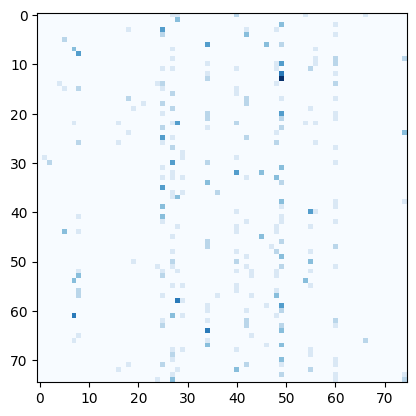

In [27]:
# Load your validation data and get model predictions
validation_data = valid_data  # Load your validation data
validation_labels = valid_label  # True labels for validation data

# Assuming 'model' is your trained model
predicted_labels = trained_model.predict(valid_data)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert one-hot encoded predictions to class labels

# Calculate the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(25, 16))  # 크기를 조절합니다.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_processor.get_vocabulary)
disp.plot(cmap=plt.cm.Blues, values_format='%d')  # 값 형식을 정수로 지정하기 위해 '%d'를 사용합니다.
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


14/14 [==============================] - 0s 20ms/step


c:\Users\7qrea\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.draw()
c:\Users\7qrea\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47157 (\N{HANGUL SYLLABLE RYEOB}) missing from current font.
  fig.canvas.draw()
c:\Users\7qrea\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.draw()
c:\Users\7qrea\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  fig.canvas.draw()
c:\Users\7qrea\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.draw()
c:\Users\7qrea\AppData\Local\Programs\Pyt

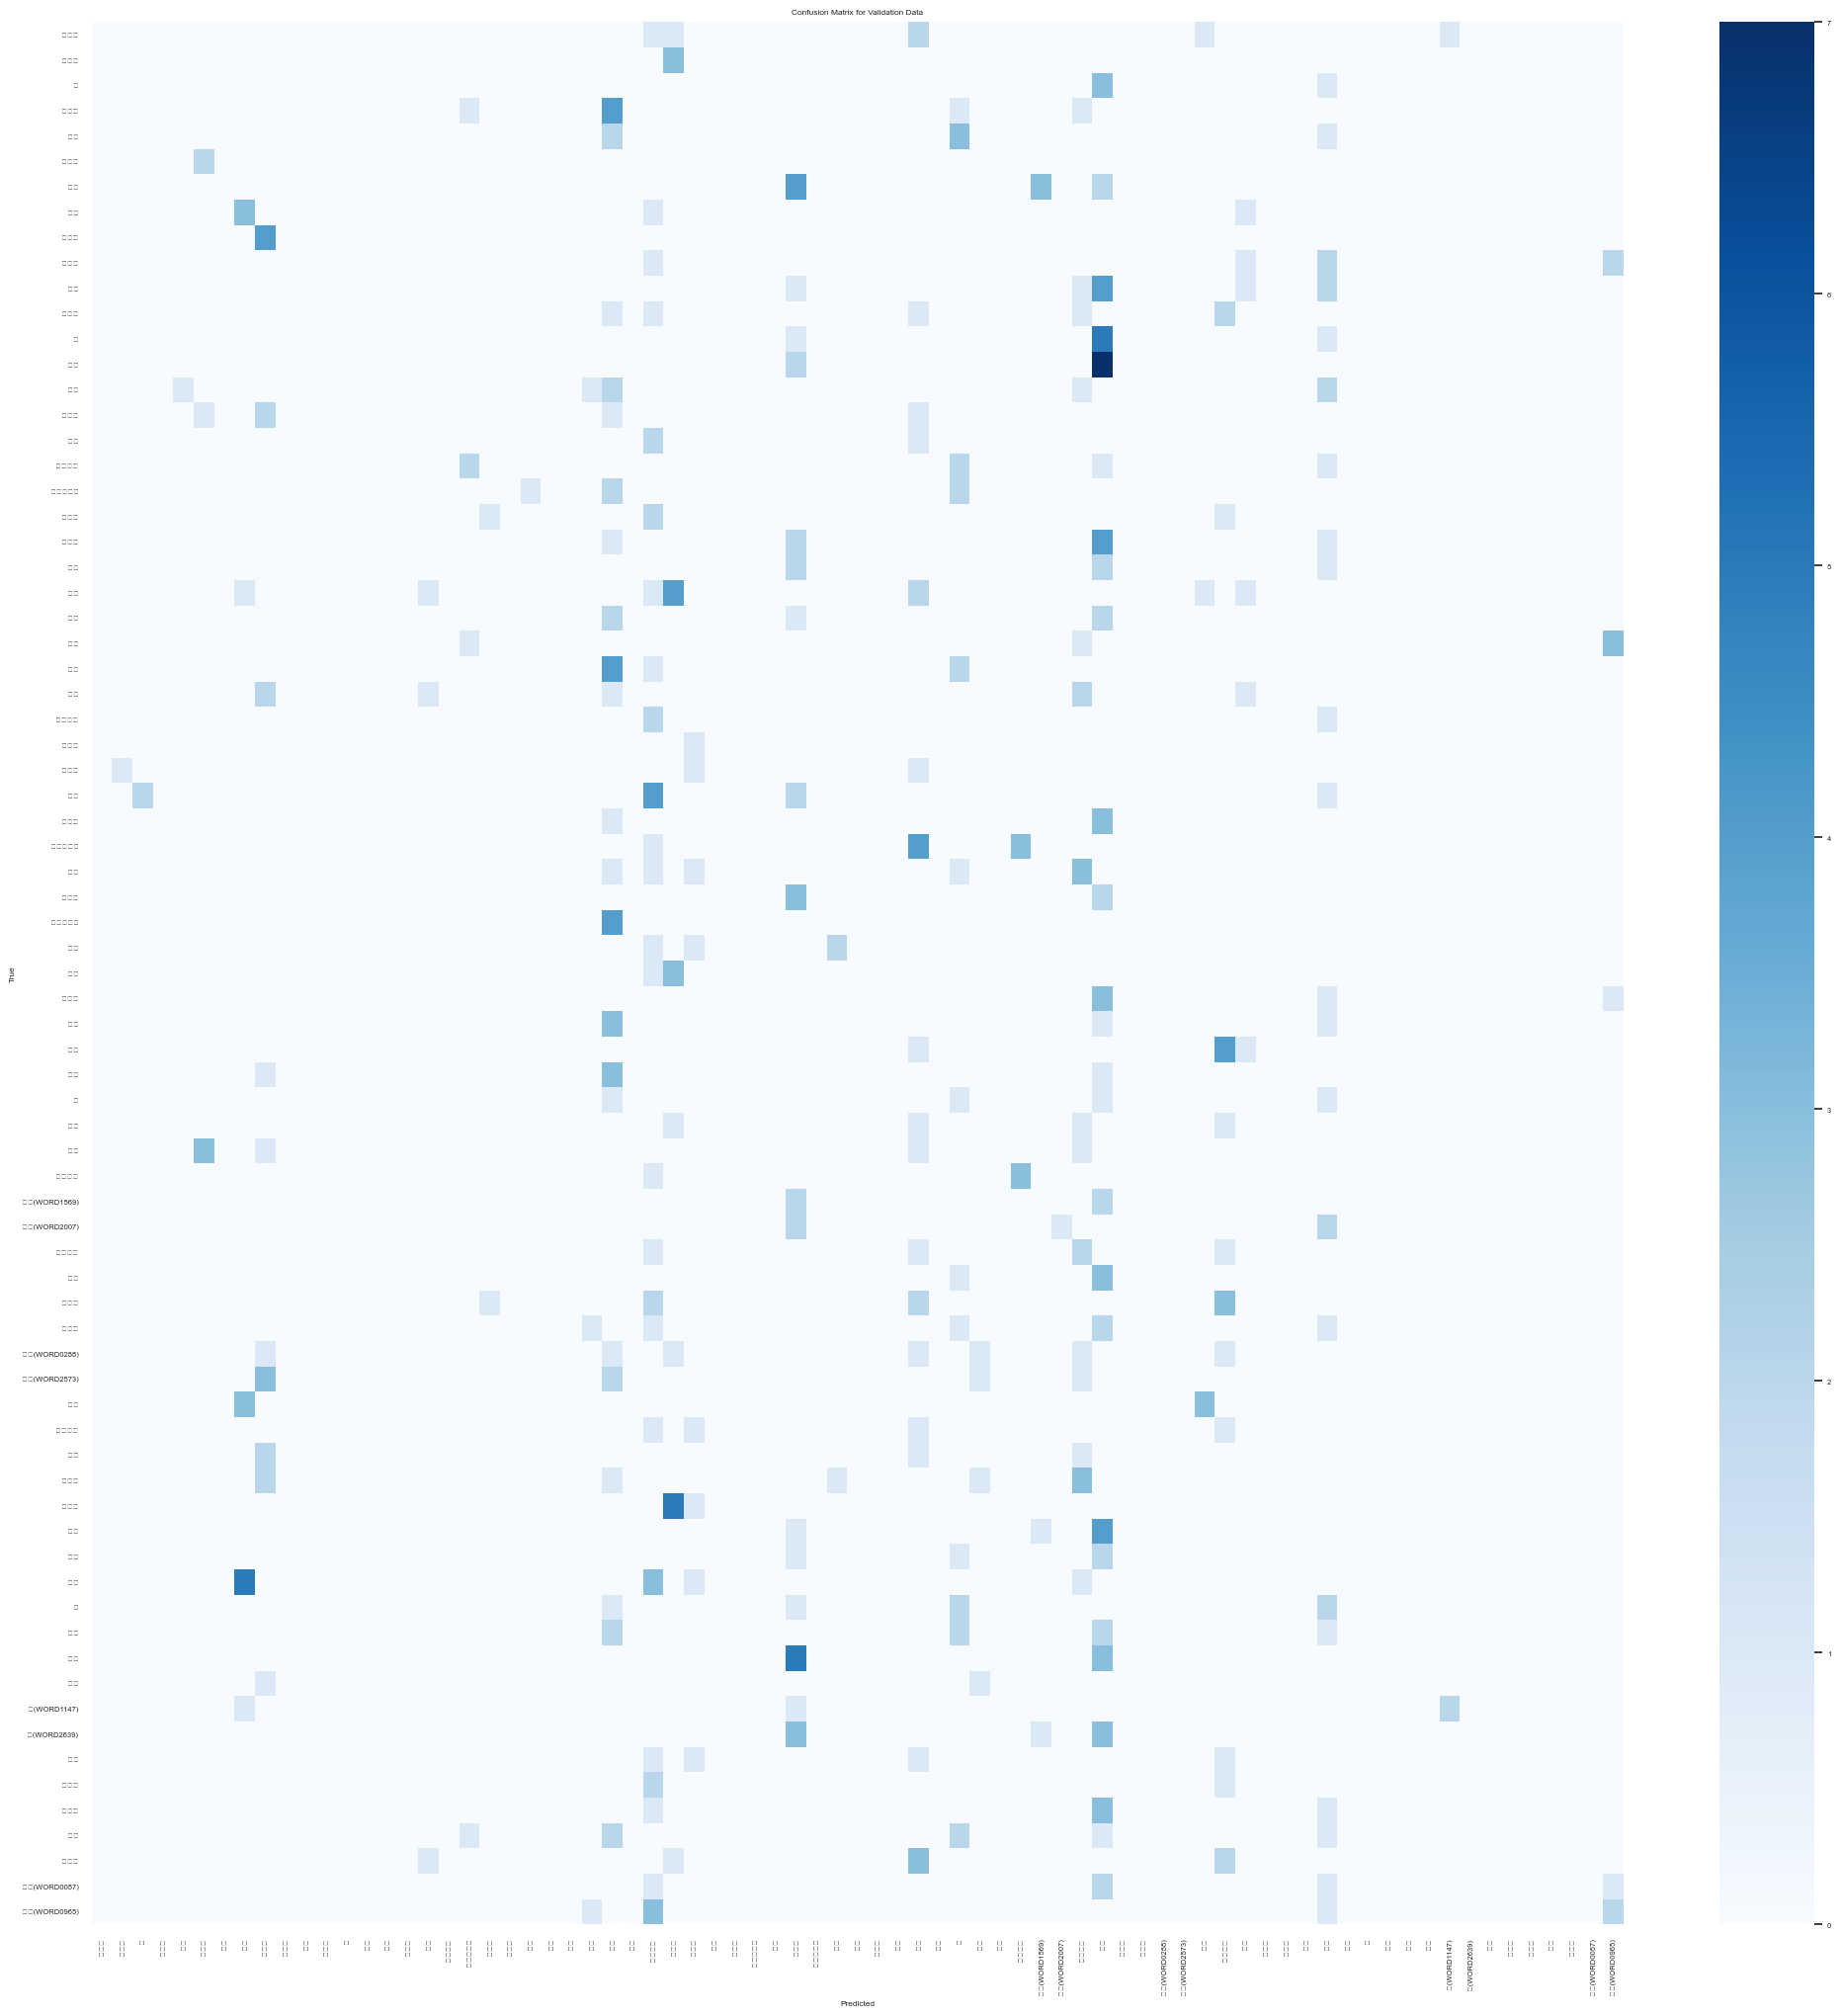

In [28]:
import seaborn as sns
# Load your validation data and get model predictions
validation_data = valid_data  # Load your validation data
validation_labels = valid_label  # True labels for validation data

predicted_labels = trained_model.predict(validation_data)
predicted_labels = np.argmax(predicted_labels, axis=1)  # 원핫 인코딩된 예측을 클래스 레이블로 변환합니다.

# Confusion matrix를 계산합니다.
cm = confusion_matrix(validation_labels, predicted_labels)

# 클래스 레이블을 설정합니다.
class_labels = label_processor.get_vocabulary()  # 클래스 레이블을 가져옵니다.

# Confusion matrix를 시각화합니다.
plt.figure(figsize=(25,25))  # 이미지 크기 설정
sns.set(font_scale=0.5)  # 글꼴 크기 설정

# Seaborn을 사용하여 heatmap을 그립니다.
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Inference

In [29]:
data = {
    'filename': [
        '치료법_박태휘.mp4',
        '치료법_문성우.mp4',
        '여드름_박태휘.mp4',
        '막히다_문성우.mp4',
        '코_채성혁.mp4',
        '팔_채성혁.mp4',
        '아프다_채성혁.mp4',
        '팔_이선여.mp4'
    ],
    'label':[
        '치료법',
        '치료법',
        '여드름',
        '막히다',
        '코',
        '팔',
        '아프다',
        '팔'
    ]
}

In [30]:
test_data1 = pd.DataFrame(data)
test_data1

,filename,label
0,치료법_박태휘.mp4,치료법
1,치료법_문성우.mp4,치료법
2,여드름_박태휘.mp4,여드름
3,막히다_문성우.mp4,막히다
4,코_채성혁.mp4,코
5,팔_채성혁.mp4,팔
6,아프다_채성혁.mp4,아프다
7,팔_이선여.mp4,팔


In [31]:
test_label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(test_data1["label"])
)
print(test_label_processor.get_vocabulary())

['막히다', '아프다', '여드름', '치료법', '코', '팔']


In [32]:
##_____________________________________
## 원래 코드
##_____________________________________
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["filename"].values.tolist()
    labels = df["label"].values
    labels = test_label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    with tqdm(total=num_samples) as pbar:  # 하나의 전체 진행 막대를 생성
      # Use tqdm with total=num_samples to track the overall progress
      for idx, path in enumerate(video_paths):  # tqdm 사용
          # Gather all its frames and add a batch dimension.
          frames = load_video(os.path.join(root_dir, path))
          frames = frames[None, ...]

          # Initialize placeholders to store the masks and features of the current video.
          temp_frame_features = np.zeros(
              shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
          )


          # Extract features from the frames of the current video.
          for i, batch in enumerate(frames):
              video_length = batch.shape[0]
              length = min(MAX_SEQ_LENGTH, video_length)
              start_frame = max(0, (video_length - MAX_SEQ_LENGTH) // 2)

              for j in range(length):
                # Use start_frame to get frames from the middle
                frame_index = start_frame + j
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, frame_index, :], verbose=0
                )

          frame_features[idx,] = temp_frame_features.squeeze()
          pbar.update(1)
    return frame_features, labels
test_video_dir = 'testdata'
test_data, test_labels = prepare_all_videos(test_data1, test_video_dir)


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


In [33]:
for idx, (video_frame_features, label, video_filename) in enumerate(zip(test_data, test_labels, test_data1["label"].values)):
    probabilities = trained_model.predict(video_frame_features[None, ...])[0]
    class_vocab = label_processor.get_vocabulary()

    print(f"영상{idx+1} 라벨 {video_filename}")

    sorted_indices = np.argsort(probabilities)[::-1][:2]  # 상위 2개 확률의 인덱스
    for i in sorted_indices:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")


1/1 [==============================] - 0s 46ms/step
영상1 라벨 치료법
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 31ms/step
영상2 라벨 치료법
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 33ms/step
영상3 라벨 여드름
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 30ms/step
영상4 라벨 막히다
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 28ms/step
영상5 라벨 코
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 32ms/step
영상6 라벨 팔
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 32ms/step
영상7 라벨 아프다
  붓다: 97.21%
  발가락:  2.32%
1/1 [==============================] - 0s 34ms/step
영상8 라벨 팔
  붓다: 97.21%
  발가락:  2.32%
